In [1]:
%pip install -q torch --upgrade
%pip install -q foolbox

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
import time
import copy
import random

import numpy as np

import torch
import torch.nn.functional as F

from torch import nn
from torch import linalg
from torch.optim import SGD, Optimizer
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from torchvision import transforms, datasets, models

import foolbox as fb

import matplotlib.pyplot as plt

from utils_ods_attack import ods_attack
from utils_general import train, test, short_test
from utils_attacks import whitebox_attack, blackbox_attack_steps
from utils_data import get_dataloader

In [3]:
# reproducibility issues
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
# !unzip tiny-imagenet-200.zip

In [5]:
dataset_cifar_valid_test = datasets.CIFAR100(
    root="./",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

dataset_cifar_valid, dataset_cifar_test = torch.utils.data.random_split(dataset_cifar_valid_test, [5000, 5000], 
                                                                        generator=torch.Generator().manual_seed(42))

Files already downloaded and verified


In [6]:
class OurResNetModel(nn.Module):
    """
    Small class to initialize ResNet
    
    """
    def __init__(self, pretrained_bool, num_of_classes):
        super().__init__()
        
        self.model_resnet = models.resnet18(pretrained=pretrained_bool) # 18 34 50 101 152
        self.model_resnet.fc = nn.Linear(self.model_resnet.fc.in_features, num_of_classes, bias=False)

    def forward(self, x):
        return self.model_resnet(x)

### Parameters to choose

In [7]:
#!g1.1
epsilons_ = [0.0, 0.001, 0.01, 0.03, 0.05, 0.1, 0.5, 1.0]
steps_ = [1000, 2000, 3000, 4000, 5000] # , 5000, 7500, 10000

In [8]:
#!g1.1
DATA_NAME, MODEL_NAME = 'cifar', 'resnet18'

if DATA_NAME == 'imagenet':
    data_loader_test_ = get_dataloader('tiny-imagenet-200/', 'test', batch_size=2000)
    NUM_OF_CLASSES = 200
else:
    data_loader_test_ = DataLoader(dataset_cifar_test, batch_size=5000, shuffle=False)
    NUM_OF_CLASSES = 100

### All below make attacks for parameters you choose above (with picture results)

In [9]:
#!g1.1
model = OurResNetModel(False, NUM_OF_CLASSES)

checkpoint = torch.load(f'checkpoint_{DATA_NAME}_{MODEL_NAME}_baseline.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.eval(); print()

In [ ]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# baseline_CW = whitebox_attack(model, data_loader_test_, attack_name='CW', epsilons=epsilons_, 
#                               plot=False, save=True, aug_type=f'baseline_{DATA_NAME}_{MODEL_NAME}', device=device)
# baseline_PGD = whitebox_attack(model, data_loader_test_, attack_name='PGD', epsilons=epsilons_, 
#                                plot=False, save=True, aug_type=f'baseline_{DATA_NAME}_{MODEL_NAME}', device=device)
# baseline_LinfFastGradientAttack = whitebox_attack(model, data_loader_test_, attack_name='LinfFastGradientAttack', epsilons=epsilons_, 
#                                                   plot=False, save=True, aug_type=f'baseline_{DATA_NAME}_{MODEL_NAME}', device=device)

baseline_Boundary = blackbox_attack_steps(model, data_loader_test_, attack_name='Boundary', epsilons=[1], steps=steps_, 
                                          plot=False, save=True, aug_type=f'baseline_{DATA_NAME}_{MODEL_NAME}', device=device)

Clear accuracy on images without adversarial attack 0.5139999985694885


In [ ]:
#!g1.1
del model

In [ ]:
#!g1.1
model = OurResNetModel(False, NUM_OF_CLASSES) # 100 - cifar, 200 - imagenet

checkpoint = torch.load(f'checkpoint_{DATA_NAME}_{MODEL_NAME}_pixeldp.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.eval(); print()

In [ ]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# pixeldp_CW = whitebox_attack(model, data_loader_test_, attack_name='CW', epsilons=epsilons_, 
#                              plot=False, save=True, aug_type=f'pixeldp_{DATA_NAME}_{MODEL_NAME}', device=device)
# pixeldp_PGD = whitebox_attack(model, data_loader_test_, attack_name='PGD', epsilons=epsilons_, 
#                               plot=False, save=True, aug_type=f'pixeldp_{DATA_NAME}_{MODEL_NAME}', device=device)
# pixeldp_LinfFastGradientAttack = whitebox_attack(model, data_loader_test_, attack_name='LinfFastGradientAttack', epsilons=epsilons_, 
#                                                  plot=False, save=True, aug_type=f'pixeldp_{DATA_NAME}_{MODEL_NAME}', device=device)

pixeldp_Boundary = blackbox_attack_steps(model, data_loader_test_, attack_name='Boundary', epsilons=[1], steps=steps_, 
                                         plot=False, save=True, aug_type=f'pixeldp_{DATA_NAME}_{MODEL_NAME}', device=device)

In [ ]:
#!g1.1
del model

In [ ]:
#!g1.1
model = OurResNetModel(False, NUM_OF_CLASSES) # 100 - cifar, 200 - imagenet

checkpoint = torch.load(f'checkpoint_{DATA_NAME}_{MODEL_NAME}_ods.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.eval(); print()

In [ ]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# ods_CW = whitebox_attack(model, data_loader_test_, attack_name='CW', epsilons=epsilons_, 
#                          plot=False, save=True, aug_type=f'ODS_{DATA_NAME}_{MODEL_NAME}', device=device)
# ods_PGD = whitebox_attack(model, data_loader_test_, attack_name='PGD', epsilons=epsilons_, 
#                           plot=False, save=True, aug_type=f'ODS_{DATA_NAME}_{MODEL_NAME}', device=device)
# ods_LinfFastGradientAttack = whitebox_attack(model, data_loader_test_, attack_name='LinfFastGradientAttack', epsilons=epsilons_, 
#                                              plot=False, save=True, aug_type=f'ODS_{DATA_NAME}_{MODEL_NAME}', device=device)

ods_Boundary = blackbox_attack_steps(model, data_loader_test_, attack_name='Boundary', epsilons=[1], steps=steps_, 
                                     plot=False, save=True, aug_type=f'ODS_{DATA_NAME}_{MODEL_NAME}', device=device)

In [ ]:
#!g1.1
del model

### Result plots

In [ ]:
DATA_NAME, MODEL_NAME = 'cifar', 'resnet50'

epsilons_ = [0.0, 0.001, 0.01, 0.03, 0.05, 0.1, 0.5, 1.0]
steps_ = [1000, 2000, 3000, 4000, 5000]

baseline_CW = np.load(f'CW_baseline_{DATA_NAME}_{MODEL_NAME}.npy')
pixeldp_CW = np.load(f'CW_pixeldp_{DATA_NAME}_{MODEL_NAME}.npy')
ods_CW = np.load(f'CW_ODS_{DATA_NAME}_{MODEL_NAME}.npy')

baseline_PGD = np.load(f'PGD_baseline_{DATA_NAME}_{MODEL_NAME}.npy')
pixeldp_PGD = np.load(f'PGD_pixeldp_{DATA_NAME}_{MODEL_NAME}.npy')
ods_PGD = np.load(f'PGD_ODS_{DATA_NAME}_{MODEL_NAME}.npy')

baseline_LinfFastGradientAttack = np.load(f'LinfFastGradientAttack_baseline_{DATA_NAME}_{MODEL_NAME}.npy')
pixeldp_LinfFastGradientAttack = np.load(f'LinfFastGradientAttack_pixeldp_{DATA_NAME}_{MODEL_NAME}.npy')
ods_LinfFastGradientAttack = np.load(f'LinfFastGradientAttack_ODS_{DATA_NAME}_{MODEL_NAME}.npy')

baseline_Boundary = np.load(f'Boundary_baseline_{DATA_NAME}_{MODEL_NAME}.npy')
pixeldp_Boundary = np.load(f'Boundary_pixeldp_{DATA_NAME}_{MODEL_NAME}.npy')
ods_Boundary = np.load(f'Boundary_ODS_{DATA_NAME}_{MODEL_NAME}.npy')

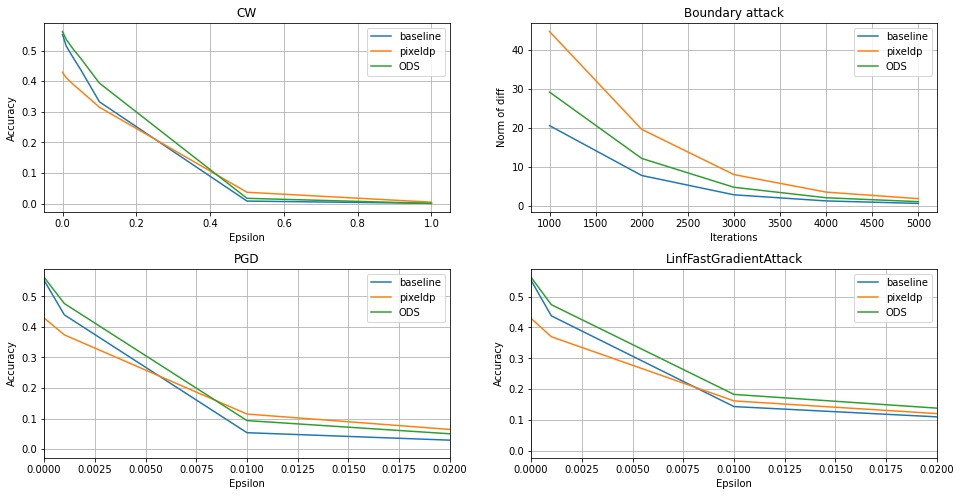

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.3)

ax[0, 0].plot(epsilons_, baseline_CW, label='baseline')
ax[0, 0].plot(epsilons_, pixeldp_CW, label='pixeldp')
ax[0, 0].plot(epsilons_, ods_CW, label='ODS')

# ax[0, 0].set_yscale('log')
# ax[0, 0].set_xlim(0., 0.8)
ax[0, 0].legend()
ax[0, 0].grid()
ax[0, 0].set_xlabel('Epsilon')
ax[0, 0].set_ylabel('Accuracy')
ax[0, 0].set_title('CW')

ax[1, 0].plot(epsilons_, baseline_PGD, label='baseline')
ax[1, 0].plot(epsilons_, pixeldp_PGD, label='pixeldp')
ax[1, 0].plot(epsilons_, ods_PGD, label='ODS')

# ax[1, 0].set_yscale('log')
ax[1, 0].set_xlim(0., 0.02)
ax[1, 0].legend()
ax[1, 0].grid()
ax[1, 0].set_xlabel('Epsilon')
ax[1, 0].set_ylabel('Accuracy')
ax[1, 0].set_title('PGD')

ax[0, 1].plot(steps_, baseline_Boundary, label='baseline')
ax[0, 1].plot(steps_, pixeldp_Boundary, label='pixeldp')
ax[0, 1].plot(steps_, ods_Boundary, label='ODS')

# ax[0, 1].set_yscale('log')
# ax[0, 1].set_xlim(0., 0.02)
ax[0, 1].legend()
ax[0, 1].grid()
ax[0, 1].set_xlabel('Iterations')
ax[0, 1].set_ylabel('Norm of diff')
ax[0, 1].set_title('Boundary attack')

ax[1, 1].plot(epsilons_, baseline_LinfFastGradientAttack, label='baseline')
ax[1, 1].plot(epsilons_, pixeldp_LinfFastGradientAttack, label='pixeldp')
ax[1, 1].plot(epsilons_, ods_LinfFastGradientAttack, label='ODS')

# ax[1, 1].set_yscale('log')
ax[1, 1].set_xlim(0., 0.02)
ax[1, 1].legend()
ax[1, 1].grid()
ax[1, 1].set_xlabel('Epsilon')
ax[1, 1].set_ylabel('Accuracy')
ax[1, 1].set_title('LinfFastGradientAttack')

plt.show()

fig.savefig(f'attacks_{DATA_NAME}_{MODEL_NAME}.png')